import libraries

In [ ]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 6.8 MB/s 
     |████████████████████████████████| 596 kB 53.9 MB/s 
     |████████████████████████████████| 6.6 MB 45.6 MB/s 
     |████████████████████████████████| 101 kB 9.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 7.9 MB/s 
     |████████████████████████████████| 140 kB 71.8 MB/s 
     |████████████████████████████████| 1.1 MB 63.0 MB/s 
     |████████████████████████████████| 212 kB 65.7 MB/s 
     |████████████████████████████████| 127 kB 68.1 MB/s 
     |████████████████████████████████| 271 kB 69.4 MB/s 
     |████████████████████████████████| 94 kB 1.1 MB/s 
     |██████████████

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import BertForQuestionAnswering #model
from transformers import BertTokenizer #tokenizer

dataset loading from huggingface

In [ ]:
from datasets import load_dataset

dataset = load_dataset("squad")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})


Use SQuAD validation dataset to inference model fine-tuned on SQuAD train dataset

In [ ]:
test_data = dataset["validation"]

In [ ]:
print(test_data)

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 10570
})


load model, tokenizer

In [ ]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Inference stage

In [ ]:
random_num = 245 #choose random index in test dataset

In [ ]:
# random_num = np.random.randint(0,len(test_data))
question = test_data["question"][random_num]
text = test_data["context"][random_num]
GT = test_data["answers"][random_num]

In [ ]:
# print(test_data[84])

In [ ]:
# print(GT['text'][:])

In [ ]:
print("random_num is {}".format(random_num))

random_num is 245


Encoding using loaded tokenizer

In [ ]:
input_ids = tokenizer.encode(question, text)
print("The input has a total of {} tokens.".format(len(input_ids)))

The input has a total of 257 tokens.


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)
# for token, id in zip(tokens, input_ids):
#     print('{:8}{:8,}'.format(token,id))

segment embedding to differentiate question, text

In [ ]:
#first occurence of [SEP] token
sep_idx = input_ids.index(tokenizer.sep_token_id)
print("SEP token index: ", sep_idx)
#number of tokens in segment A (question) - this will be one more than the sep_idx as the index in Python starts from 0
num_seg_a = sep_idx+1
print("Number of tokens in segment A: ", num_seg_a)
#number of tokens in segment B (text)
num_seg_b = len(input_ids) - num_seg_a
print("Number of tokens in segment B: ", num_seg_b)
#creating the segment ids
segment_ids = [0]*num_seg_a + [1]*num_seg_b
#making sure that every input token has a segment id
assert len(segment_ids) == len(input_ids)

SEP token index:  11
Number of tokens in segment A:  12
Number of tokens in segment B:  245


feed question, text to loaded model

In [ ]:
#token input_ids to represent the input and token segment_ids to differentiate our segments - question and text
output = model(torch.tensor([input_ids]),  token_type_ids=torch.tensor([segment_ids]))

get most probable start, end words
answers are provided only if the end token is after the start token

In [ ]:
print("\nText:\n{}".format(text.capitalize()))
print("\nQuestion:\n{}".format(question.capitalize()))

#tokens with highest start and end scores
answer_start = torch.argmax(output.start_logits)
answer_end = torch.argmax(output.end_logits)
print("\nanswer_start is {}".format(answer_start))
print("answer_end is {}".format(answer_end))
print(tokens[answer_start:answer_start+1])
print(tokens[answer_end:answer_end+1])

if answer_end >= answer_start:
    answer = " ".join(tokens[answer_start:answer_end+1])
    print("\nPredicted Answer:\n{}.".format(answer.capitalize()))
else:
    print("\nPredicted Answer:")
    print("unable to find the answer to this question. Can you please ask another question?")

print("\nOriginal answer:\n{}".format(GT))  
# print("\nQuestion:\n{}".format(question.capitalize()))
# print("\nAnswer:\n{}.".format(answer.capitalize()))


Text:
The panthers defense gave up just 308 points, ranking sixth in the league, while also leading the nfl in interceptions with 24 and boasting four pro bowl selections. pro bowl defensive tackle kawann short led the team in sacks with 11, while also forcing three fumbles and recovering two. fellow lineman mario addison added 6½ sacks. the panthers line also featured veteran defensive end jared allen, a 5-time pro bowler who was the nfl's active career sack leader with 136, along with defensive end kony ealy, who had 5 sacks in just 9 starts. behind them, two of the panthers three starting linebackers were also selected to play in the pro bowl: thomas davis and luke kuechly. davis compiled 5½ sacks, four forced fumbles, and four interceptions, while kuechly led the team in tackles (118) forced two fumbles, and intercepted four passes of his own. carolina's secondary featured pro bowl safety kurt coleman, who led the team with a career high seven interceptions, while also racking up 

Visualizing start&end word scores

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

In [ ]:
# # Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = output.start_logits.detach().numpy().flatten()
e_scores = output.end_logits.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

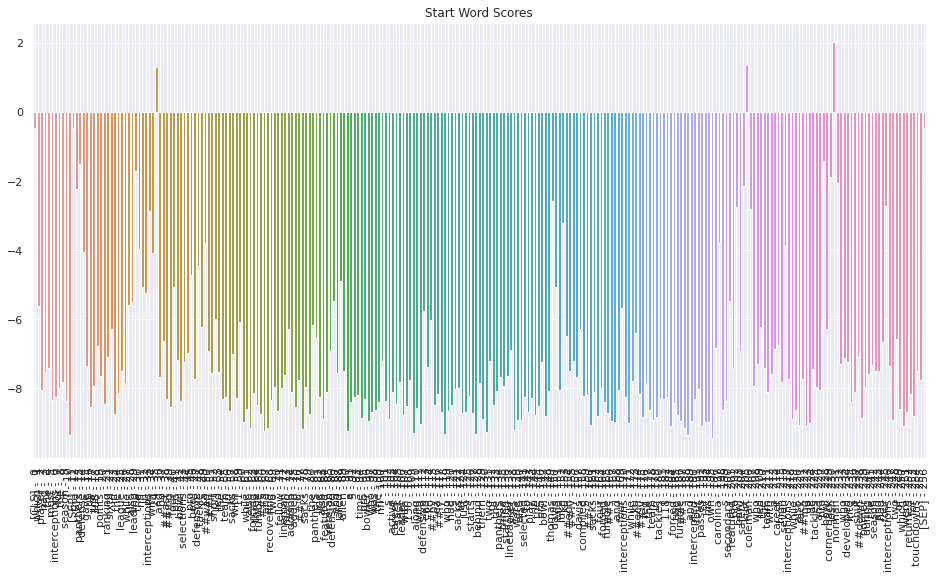

In [ ]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

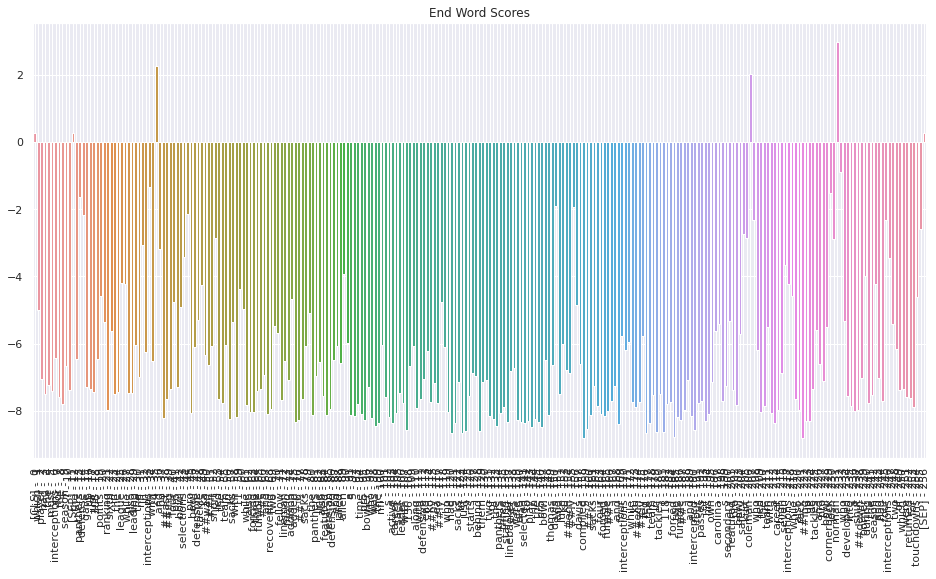

In [ ]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

question-answering process into a function

In [ ]:
# def question_answer(question, text, GT):
    
#     #tokenize question and text as a pair
#     input_ids = tokenizer.encode(question, text)
    
#     #string version of tokenized ids
#     tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
#     #segment IDs
#     #first occurence of [SEP] token
#     sep_idx = input_ids.index(tokenizer.sep_token_id)
#     #number of tokens in segment A (question)
#     num_seg_a = sep_idx+1
#     #number of tokens in segment B (text)
#     num_seg_b = len(input_ids) - num_seg_a
    
#     #list of 0s and 1s for segment embeddings
#     segment_ids = [0]*num_seg_a + [1]*num_seg_b
#     assert len(segment_ids) == len(input_ids)
    
#     #model output using input_ids and segment_ids
#     output = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
    
#     #reconstructing the answer
#     answer_start = torch.argmax(output.start_logits)
#     answer_end = torch.argmax(output.end_logits)
#     # answer = ""
#     if answer_end >= answer_start:
#         answer = tokens[answer_start]
#         for i in range(answer_start+1, answer_end+1):
#             if tokens[i][0:2] == "##":
#                 answer += tokens[i][2:]
#             else:
#                 answer += " " + tokens[i]
#     else:
#       answer = "Unable to find the answer to your question."
#       # print("hello")

#     if answer.startswith("[CLS]"):
#         answer = "Unable to find the answer to your question."
#         # print("hi")
    
#     print("Text:\n{}".format(text.capitalize()))
#     print("\Question:\n{}".format(question.capitalize()))
#     print("\nPredicted answer:\n{}".format(answer.capitalize()))
#     #original answer from the dataset
#     print("Original answer:\n{}".format(GT))
    

In [ ]:
# question_answer(question, text, GT)

Text:
As opposed to broadcasts of primetime series, cbs broadcast special episodes of its late night talk shows as its lead-out programs for super bowl 50, beginning with a special episode of the late show with stephen colbert following the game. following a break for late local programming, cbs also aired a special episode of the late late show with james corden.
\Question:
What followed the late show with stephen colbert?

Predicted answer:
Super bowl 50
Original answer:
{'text': ['late local programming', 'late local programming', 'late local programming'], 'answer_start': [263, 263, 263]}
